# In context learning with examples

In [38]:
!pip install opperai
!pip install pydantic
!pip install requests

from opperai import fn, Opper
from pydantic import BaseModel
import os

os.environ["OPPER_API_KEY"] = "op-AJ28BGSXFM887D1K7ZE7" #"your-api-key"
os.environ["OPPER_PROJECT"] = "gsm8k"

### Respond with prompting

In [23]:
@fn(path="cookbook/few_shot", model="mistral/mistral-large-eu")
def respond(question: str) -> str:
    """ Create a brief response to the question. Repeat the question before answering, like "You asked... """

respond("Why is the earth round?")

"You asked: Why is the earth round? The Earth appears round because it is an oblate spheroid, meaning it is mostly spherical but slightly flattened at the poles and slightly bulging at the equator. This shape is caused by the Earth's rotation."

### Create evaluation function

In [18]:
import re

def evaluate_response(response: str) -> bool:
    
    pattern = r"^You asked (.+?), (.+?)$"

    match = re.match(pattern, response.strip())

    if match:
        return True
    else:
        return False

evaluate_response(respond("Why is the earth round?"))

False

### Create dataset for in context learning

In [22]:
class Example(BaseModel):
    question: str
    response: str

@fn(path="cookbook/generate_examples")
def expand_examples(reference: Example) -> list[Example]:
    """ Create 10 more examples in the format of the reference example, but with different questions """

reference = Example(
    question="Why is the earth round?", 
    response="You asked why the earth is round, and the earth is round because of gravity in space.")

examples = expand_examples(reference)

### Upload dataset to function

In [29]:
import requests

# Function to post examples to the endpoint
def post_example(dataset_id, input_text, output_text, comment_text):

    endpoint_url = "https://api.opper.ai/v1/datasets/" + dataset_id

    headers = {
    "x-opper-api-key": os.environ["OPPER_API_KEY"],
    "Content-Type": "application/json"
    }

    body = {
        "input": input_text,
        "output": output_text,
        "comment": comment_text
    }
    response = requests.post(endpoint_url, json=body, headers=headers)
    if response.status_code == 200:
        print("Successfully posted example:", input_text)
    else:
        print("Failed to post example:", input_text, "Status Code:", response.status_code)

# Split the examples
training_set = examples[:7]
testing_set = examples[7:]

# We locate the dataset id for the respond() function
dataset_id = "346ac7e6-9bcc-4736-8ab6-7fad8928fca8"

# Loop through examples and post each one
for example in training_set:
    comment = "Generated example for model training"
    post_example(dataset_id, example.question, example.response, comment)



Successfully posted example: Why does it rain?
Successfully posted example: What causes a rainbow?
Successfully posted example: How does a plane stay in the air?
Successfully posted example: Why do we need to sleep?
Successfully posted example: How do bees make honey?
Successfully posted example: Why do leaves change color in the fall?
Successfully posted example: What is photosynthesis?


### Test with few shot

In [36]:

@fn(path="cookbook/few_shot", model="mistral/mistral-large-eu", few_shot=True, few_shot_count=3)
def respond(question: str) -> str:
    """ Create a brief response to the question. Repeat the question before answering, like "You asked... """

for test in testing_set:
    response = respond(test.question)

    print(test.question)
    print(response)
    print(evaluate_response(response))
    print("-----------------")

How does the internet work?
You asked how the internet works, and the internet functions as a global network of interconnected computers and servers, communicating with each other using standardized protocols to exchange data packets, enabling worldwide information sharing and communication.
True
-----------------
What is the theory of relativity?
You asked what the theory of relativity is, and the theory of relativity is a scientific theory proposed by Albert Einstein that describes the laws of physics in the presence of gravity and motion, including the concepts of space-time curvature and the equivalence of mass and energy.
True
-----------------
Why do we have seasons?
You asked why we have seasons, and seasons occur due to the Earth's tilt on its axis and its orbit around the sun, which cause changes in the amount and angle of sunlight that reaches different parts of the planet.
True
-----------------


### How does other models work?

In [37]:
def get_models():
    # Define the URL and the headers for the API request
    url = 'https://api.opper.ai/api/v1/language_models'
    headers = {
        'X-OPPER-API-KEY': os.environ.get('OPPER_API_KEY'),
        'Content-Type': 'application/json'
    }

    # Make the API request
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to retrieve data:", response.status_code)
        return None

models = get_models()

for model in models:
    model_name = model.get("name")
    print(model_name)

models = models

anthropic/claude-2
anthropic/claude-3-haiku
anthropic/claude-3-opus
anthropic/claude-3-sonnet
aws/claude-3-haiku-eu
aws/claude-3-sonnet-eu
aws/titan-text-express-v1-eu
azure/gpt3-eu
azure/gpt4-eu
azure/mistral-large-eu
gcp/gemini-1.5-flash-eu
gcp/gemini-pro-1.0-eu
gcp/gemini-pro-1.5-eu
mistral/mistral-large-eu
mistral/mistral-small-eu
mistral/mistral-tiny-eu
ollama/openhermes2.5-mistral
openai/gpt3.5-turbo
openai/gpt-4o
openai/gpt4-turbo
opper/mistral-7b-instruct


### Run tests

In [59]:
opper = Opper()

function = opper.functions.get(path="cookbook/few_shot")

evaluations = {}

for model in models:

    @fn(path="cookbook/few_shot", model=model.get("name"), few_shot=True, few_shot_count=3)
    def respond(question: str) -> str:
        """ Create a brief response to the question. Repeat the question before answering, like "You asked... """

    for test in testing_set:
        try:
            response = respond(test.question)
            evaluation = evaluate_response(response)
        except Exception as e:
            print(e)
            evaluation = False

        result = {
            "model": model.get("name"),
            "response": response,
            "evaluation": evaluation
        }

        if not model.get("name") in evaluations:
            evaluations[model.get("name")] = []
        evaluations[model.get("name")].append(result)

        print(model.get("name"))
        print(response)
        print(evaluation)
        print("-----------------")


anthropic/claude-2
You asked how the internet works. The internet works by connecting many computer networks all over the world via cables, phone lines, satellites and wifi. Information is sent between these networks as small packets of data. These packets travel across various paths to reach their destination where the information is reassembled by the receiving computer.
True
-----------------
anthropic/claude-2
You asked what the theory of relativity is. The theory of relativity is a broad framework developed by Albert Einstein that describes the relationship between space and time. The two pillars of the theory are the special theory of relativity, which describes the behavior of objects moving at constant speed, and the general theory of relativity, which describes gravity as curves in the fabric of space and time.
True
-----------------
anthropic/claude-2
You asked why we have seasons, and we have seasons on Earth due to the tilt of Earth's axis of rotation relative to the plane 

### Compile results

In [60]:
passed_counts = {}

for model_name, results in evaluations.items():
    for result in results:
        if result["evaluation"]:
            if model_name in passed_counts:
                passed_counts[model_name] += 1
            else:
                passed_counts[model_name] = 1
        else:
            passed_counts[model_name] = 1

for model_name, count in passed_counts.items():
    print(f"Model {model_name} passed {count} tests.")


Model anthropic/claude-2 passed 3 tests.
Model anthropic/claude-3-haiku passed 3 tests.
Model anthropic/claude-3-opus passed 3 tests.
Model anthropic/claude-3-sonnet passed 3 tests.
Model aws/claude-3-haiku-eu passed 3 tests.
Model aws/claude-3-sonnet-eu passed 3 tests.
Model aws/titan-text-express-v1-eu passed 1 tests.
Model azure/gpt3-eu passed 3 tests.
Model azure/gpt4-eu passed 3 tests.
Model azure/mistral-large-eu passed 3 tests.
Model gcp/gemini-1.5-flash-eu passed 2 tests.
Model gcp/gemini-pro-1.0-eu passed 3 tests.
Model gcp/gemini-pro-1.5-eu passed 3 tests.
Model mistral/mistral-large-eu passed 3 tests.
Model mistral/mistral-small-eu passed 2 tests.
Model mistral/mistral-tiny-eu passed 3 tests.
Model ollama/openhermes2.5-mistral passed 1 tests.
Model openai/gpt3.5-turbo passed 3 tests.
Model openai/gpt-4o passed 3 tests.
Model openai/gpt4-turbo passed 3 tests.
Model opper/mistral-7b-instruct passed 3 tests.


  Using cached matplotlib-3.9.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Using cached pillow-10.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.0-cp311-cp311-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.2.1-cp311-cp311-macosx_11_0_arm64.whl (245 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.0-cp311-cp311-macosx_11_0_arm64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━

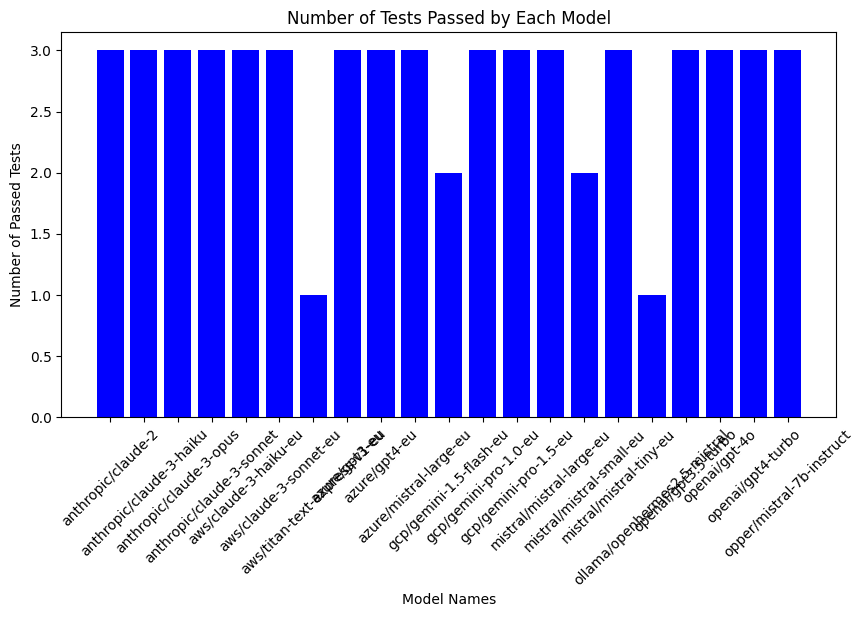

In [62]:
! pip install matplotlib
import matplotlib.pyplot as plt

# Create a bar graph of the results
model_names = list(passed_counts.keys())
pass_counts = [passed_counts[name] for name in model_names]

plt.figure(figsize=(10, 5))
plt.bar(model_names, pass_counts, color='blue')
plt.xlabel('Model Names')
plt.ylabel('Number of Passed Tests')
plt.title('Number of Tests Passed by Each Model')
plt.xticks(rotation=90)
plt.show()
